# Graph-based Random Walk

This notebook is used to construct a Human-Mouse graph through Random Walk method.

### Introduction

##### Human diffusion-based tractography

- We utilized diffusion data from the [Human Connectome Project (HCP)](https://www.humanconnectome.org/study/hcp-young-adult/data-releases), which have been preprocessed following HCP's standard pipeline.
- Further post-processing steps of tractography were carried out using [MRtrix3](http://mrtrix.readthedocs.io).

##### Mouse Tracer

- Tracer data maps neural connectivity by tracking the movement of injected tracers along axonal pathways in animal brains.
- The mouse connectome data we used was initially sourced from the [Allen Mouse Connectivity Atlas](https://connectivity.brain-map.org).

##### Embedding space generated from Human-Mouse graph

- Intra-species edges are defined by anatomical connectivity, derived from mouse viral tracer data and human tractography.
- Cross-species edges were established using transcriptomic latent embeddings from DNN model, constrained by coarse-scale anatomical hierarchies.
- For the pruned Human-Mouse graph, we used the [Node2vec algorithm by Sporns et al.](https://www.nature.com/articles/s41467-018-04614-w) to construct graph embedding.


### Define human and mouse ROIs

In [1]:
%matplotlib inline

In [2]:
human_select_cortex_region = ['A8m', 'A8dl', 'A9l', 'A6dl','A6m','A9m', 'A10m', 'A9/46d','IFJ', 'A46', 'A9/46v', 'A8vl','A6vl','A10l', 'A44d', 'IFS', 'A45c', 'A45r', 'A44op','A44v', 'A14m', 'A12/47o', 'A11l','A11m', 'A13', 'A12/47l','A32p','A32sg','A24cd','A24rv','A4hf', 'A6cdl', 'A4ul', 'A4t', 'A4tl', 'A6cvl','A1/2/3ll', 'A4ll','A1/2/3ulhf', 'A1/2/3tonIa', 'A2','A1/2/3tru','A7r', 'A7c', 'A5l', 'A7pc', 'A7ip', 'A39c', 'A39rd', 'A40rd', 'A40c', 'A39rv','A40rv',
                             'A7m', 'A5m', 'dmPOS','A31','A23d','A23c','A23v','cLinG', 'rCunG','cCunG', 'rLinG', 'vmPOS', 'mOccG', 'V5/MT+', 'OPC', 'iOccG', 'msOccG', 'lsOccG',
                             'G', 'vIa', 'dIa', 'vId/vIg', 'dIg', 'dId','A38m', 'A41/42', 'TE1.0 and TE1.2', 'A22c', 'A38l', 'A22r', 'A21c', 'A21r', 'A37dl', 'aSTS', 'A20iv', 'A37elv', 'A20r', 'A20il', 'A37vl', 'A20cl','A20cv', 'A20rv', 'A37mv', 'A37lv', 'A35/36r', 'A35/36c', 'lateral PPHC', 'A28/34', 'TH','TI','rpSTS','cpSTS']
mouse_select_cortex_region = ['ACAd', 'ACAv', 'PL','ILA', 'ORBl', 'ORBm', 'ORBvl','MOp','SSp-n', 'SSp-bfd', 'SSp-ll', 'SSp-m',
       'SSp-ul', 'SSp-tr', 'SSp-un','SSs','PTLp','RSPagl','RSPd', 'RSPv','VISpm','VISp','VISal','VISl','VISpl','AId','AIp','AIv','GU','VISC','TEa', 'PERI', 'ECT','AUDd', 'AUDp',
       'AUDpo', 'AUDv'] 

In [3]:
len(human_select_cortex_region)

105

In [4]:
len(mouse_select_cortex_region)

37

In [5]:
human_select_subcortex_region = ['mAmyg', 'lAmyg', 'CA1', 'CA4DG', 'CA2CA3', 'subiculum','Claustrum', 'head of caudate', 'body of caudate', 'Putamen',
       'posterovemtral putamen', 'nucleus accumbens','external segment of globus pallidus','internal segment of globus pallidus', 'mPMtha', 'Stha','cTtha', 'Otha',
        'mPFtha','lPFtha','rTtha', 'PPtha']
mouse_select_subcortex_region = ['LA', 'BLA', 'BMA', 'PA','CA1', 'CA2', 'CA3', 'DG', 'SUB', 'ACB', 'CP', 'FS', 'SF', 'SH','sAMY', 'PAL', 'VENT', 'SPF', 'SPA', 'PP', 'GENd', 'LAT', 'ATN',
       'MED', 'MTN', 'ILM', 'GENv', 'EPI', 'RT']

In [6]:
len(human_select_cortex_region+human_select_subcortex_region)

127

In [7]:
Human_select_region = human_select_cortex_region + human_select_subcortex_region
Mouse_select_region = mouse_select_cortex_region + mouse_select_subcortex_region

In [8]:
len(Human_select_region)

127

In [9]:
len(Mouse_select_region)

66

In [10]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle

## Generate human and mouse graph

Load human structural connectivity data and region info table

In [11]:
Human_dti_dataframe=pd.read_csv('../../tutorials/structural_connection/human_127atlas_dti.csv')

In [12]:
Human_dti_dataframe.set_index('Unnamed: 0',drop=True,inplace=True)

In [13]:
human_127atlas = pd.read_excel('../../transbrain/atlas/roi_of_bn_atlas.xlsx')

In [17]:
human_127atlas

,Anatomical Name,Full Name,Atlas Type,Left Index,Right Index,Atlas Index
0,A8m,"A8m, medial area 8",BN,1,2,1
1,A8dl,"A8dl, dorsolateral area 8",BN,3,4,2
2,A9l,"A9l, lateral area 9",BN,5,6,3
3,A6dl,"A6dl, dorsolateral area 6",BN,7,8,4
4,A6m,"A6m, medial area 6",BN,9,10,5
...,...,...,...,...,...,...
122,rTtha,"rTtha, rostral temporal thalamus",BN,237,238,123
123,PPtha,"PPtha, posterior parietal thalamus",BN,239,240,124
124,Otha,"Otha, occipital thalamus",BN,241,242,125
125,cTtha,"cTtha, caudal temporal thalamus",BN,243,244,126


In [14]:
Human_dti_dataframe.index = human_127atlas['Anatomical Name'].values.tolist()
Human_dti_dataframe.columns = human_127atlas['Anatomical Name'].values.tolist()

In [15]:
Human_dti_dataframe = Human_dti_dataframe[Human_select_region]
Human_dti_dataframe = Human_dti_dataframe.T[Human_select_region]

Visualize the structural connectivity matrix

[Text(0.5, 421.3333333333332, ''), Text(652.3333333333331, 0.5, '')]

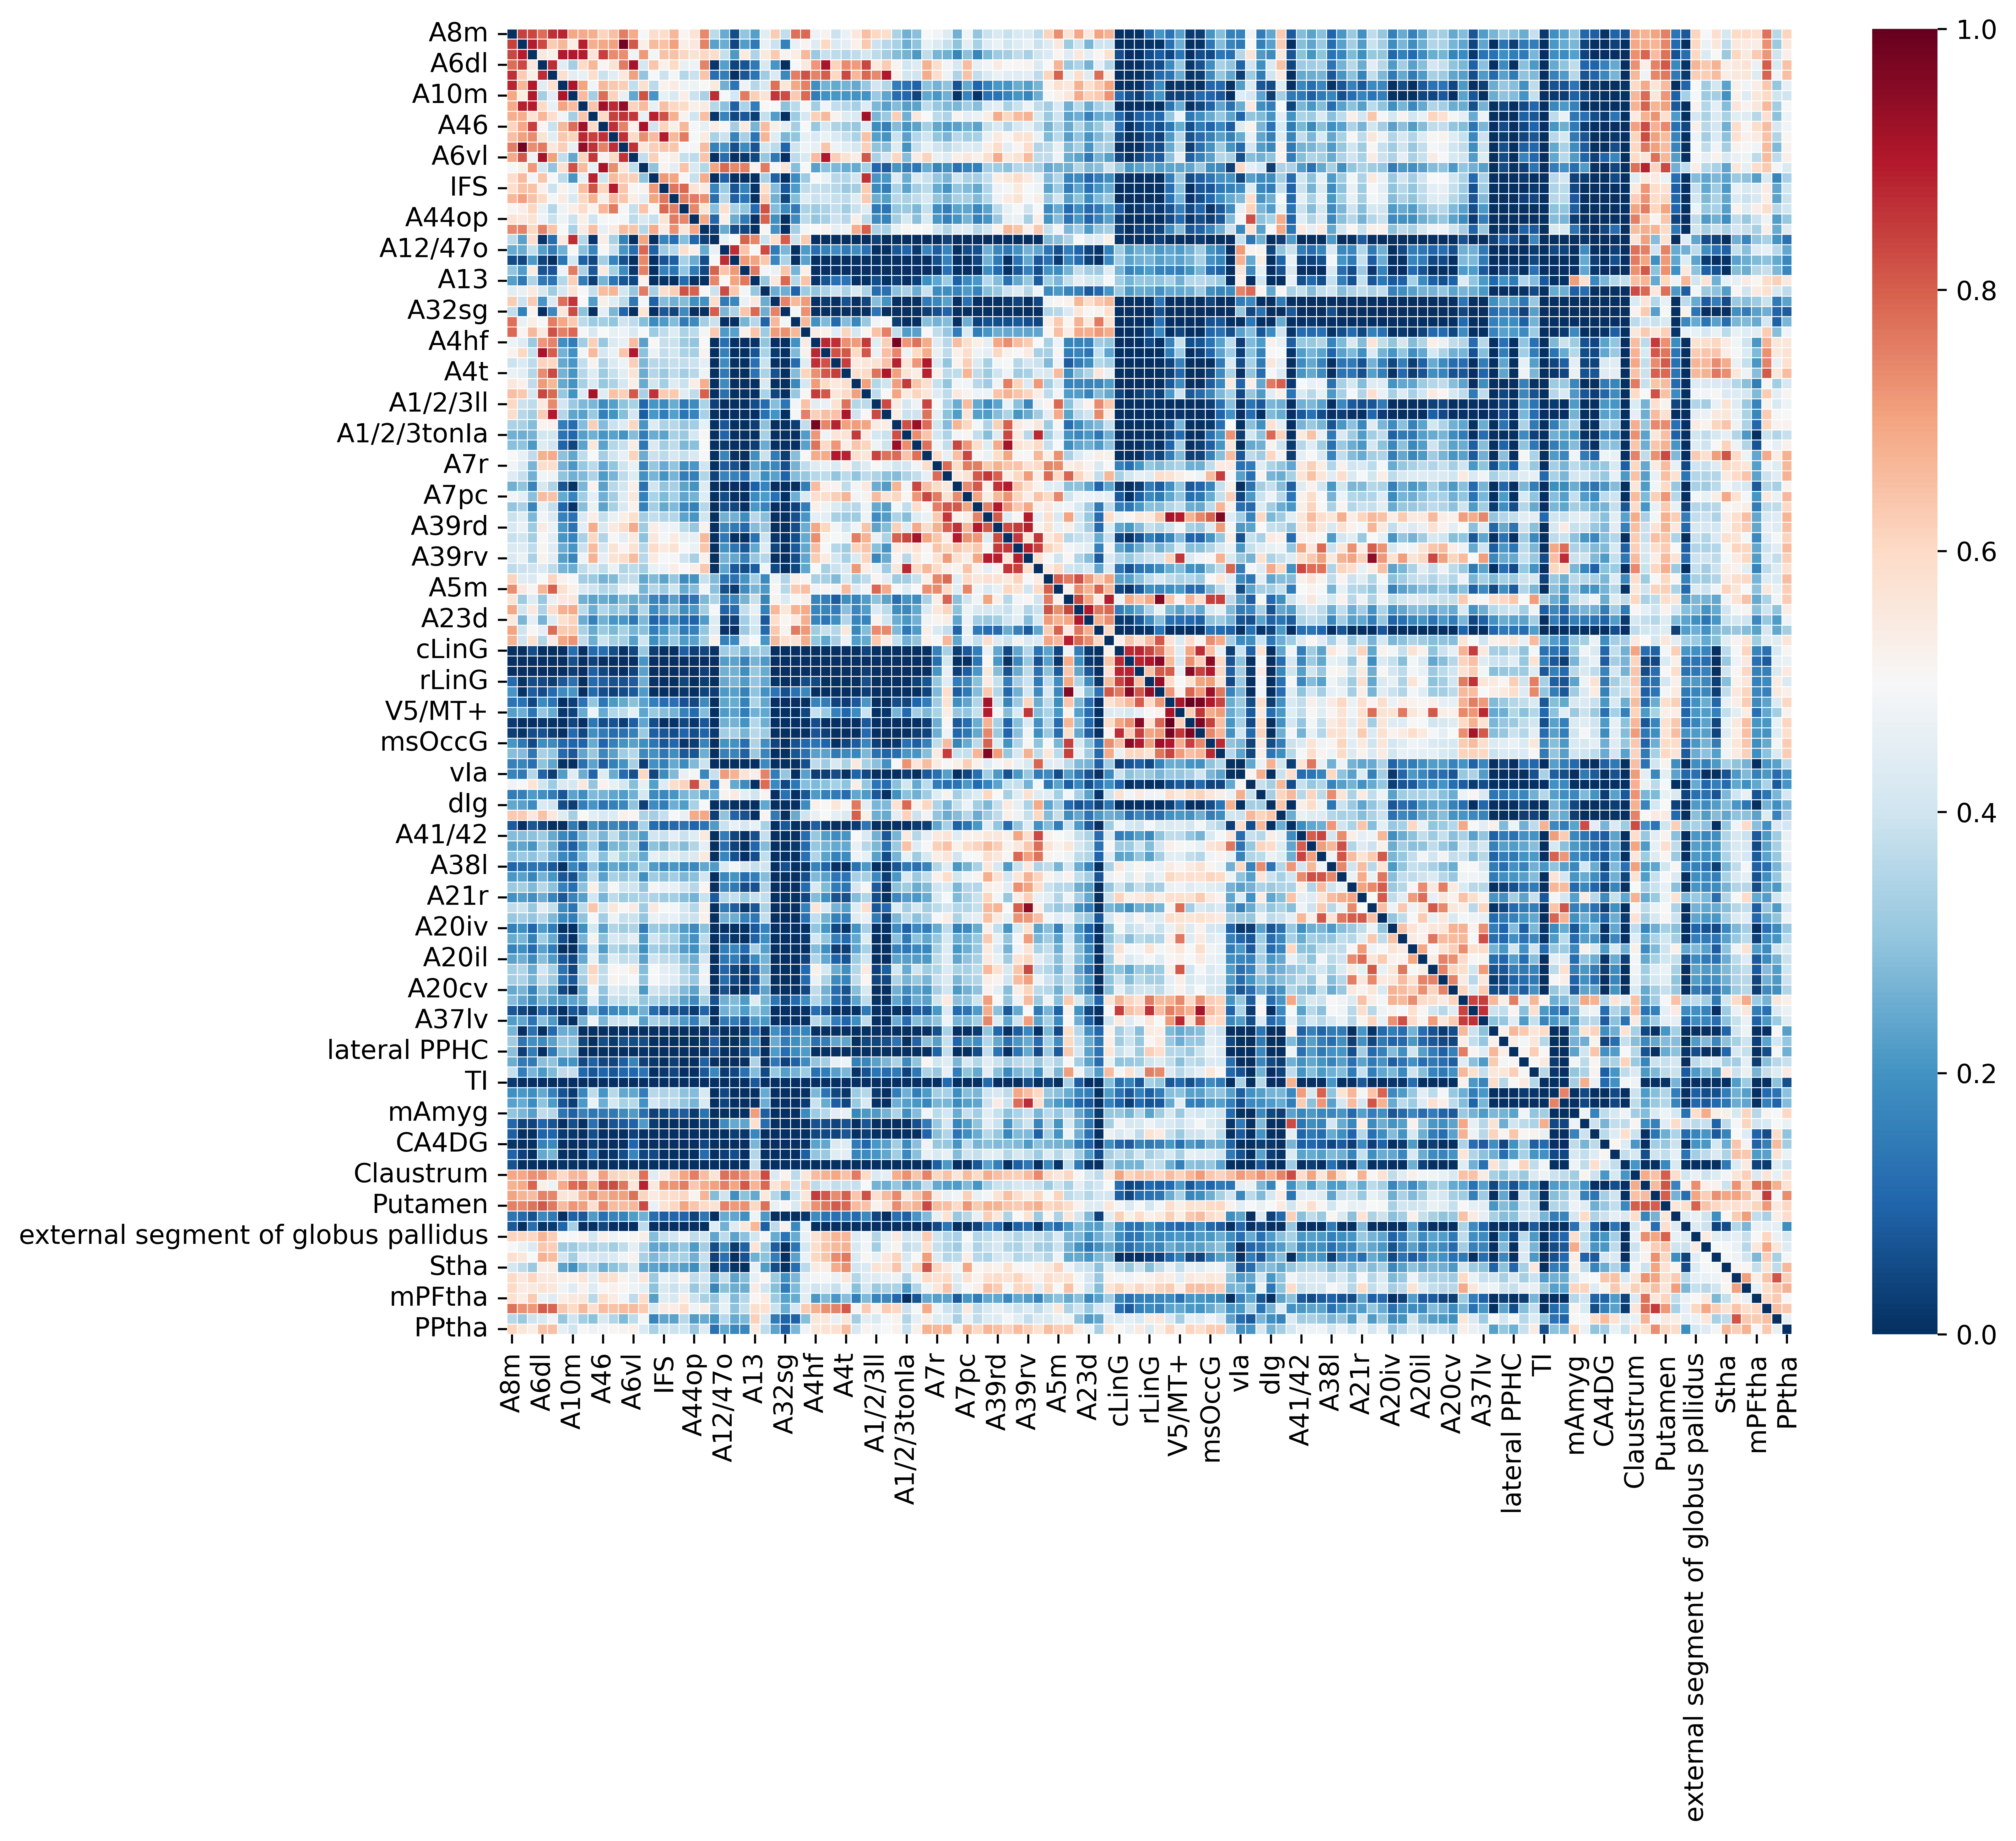

In [16]:
f, ax = plt.subplots(figsize=(11, 9),dpi=600)
sns.heatmap(Human_dti_dataframe,linewidths=0.3,cmap='RdBu_r',vmin=0)
ax.set(xlabel="", ylabel="")

Load mouse tracer data

In [19]:
Mouse_tracer_dataframe = pd.read_csv('../../tutorials/structural_connection/mouse_atlas_tracer.csv')

In [20]:
Mouse_tracer_dataframe.set_index('Unnamed: 0',drop=True,inplace=True)

In [21]:
Mouse_tracer_dataframe = Mouse_tracer_dataframe[Mouse_select_region]
Mouse_tracer_dataframe = Mouse_tracer_dataframe.T[Mouse_select_region]

Visualize the mouse tracer matrix

<Axes: xlabel='Unnamed: 0'>

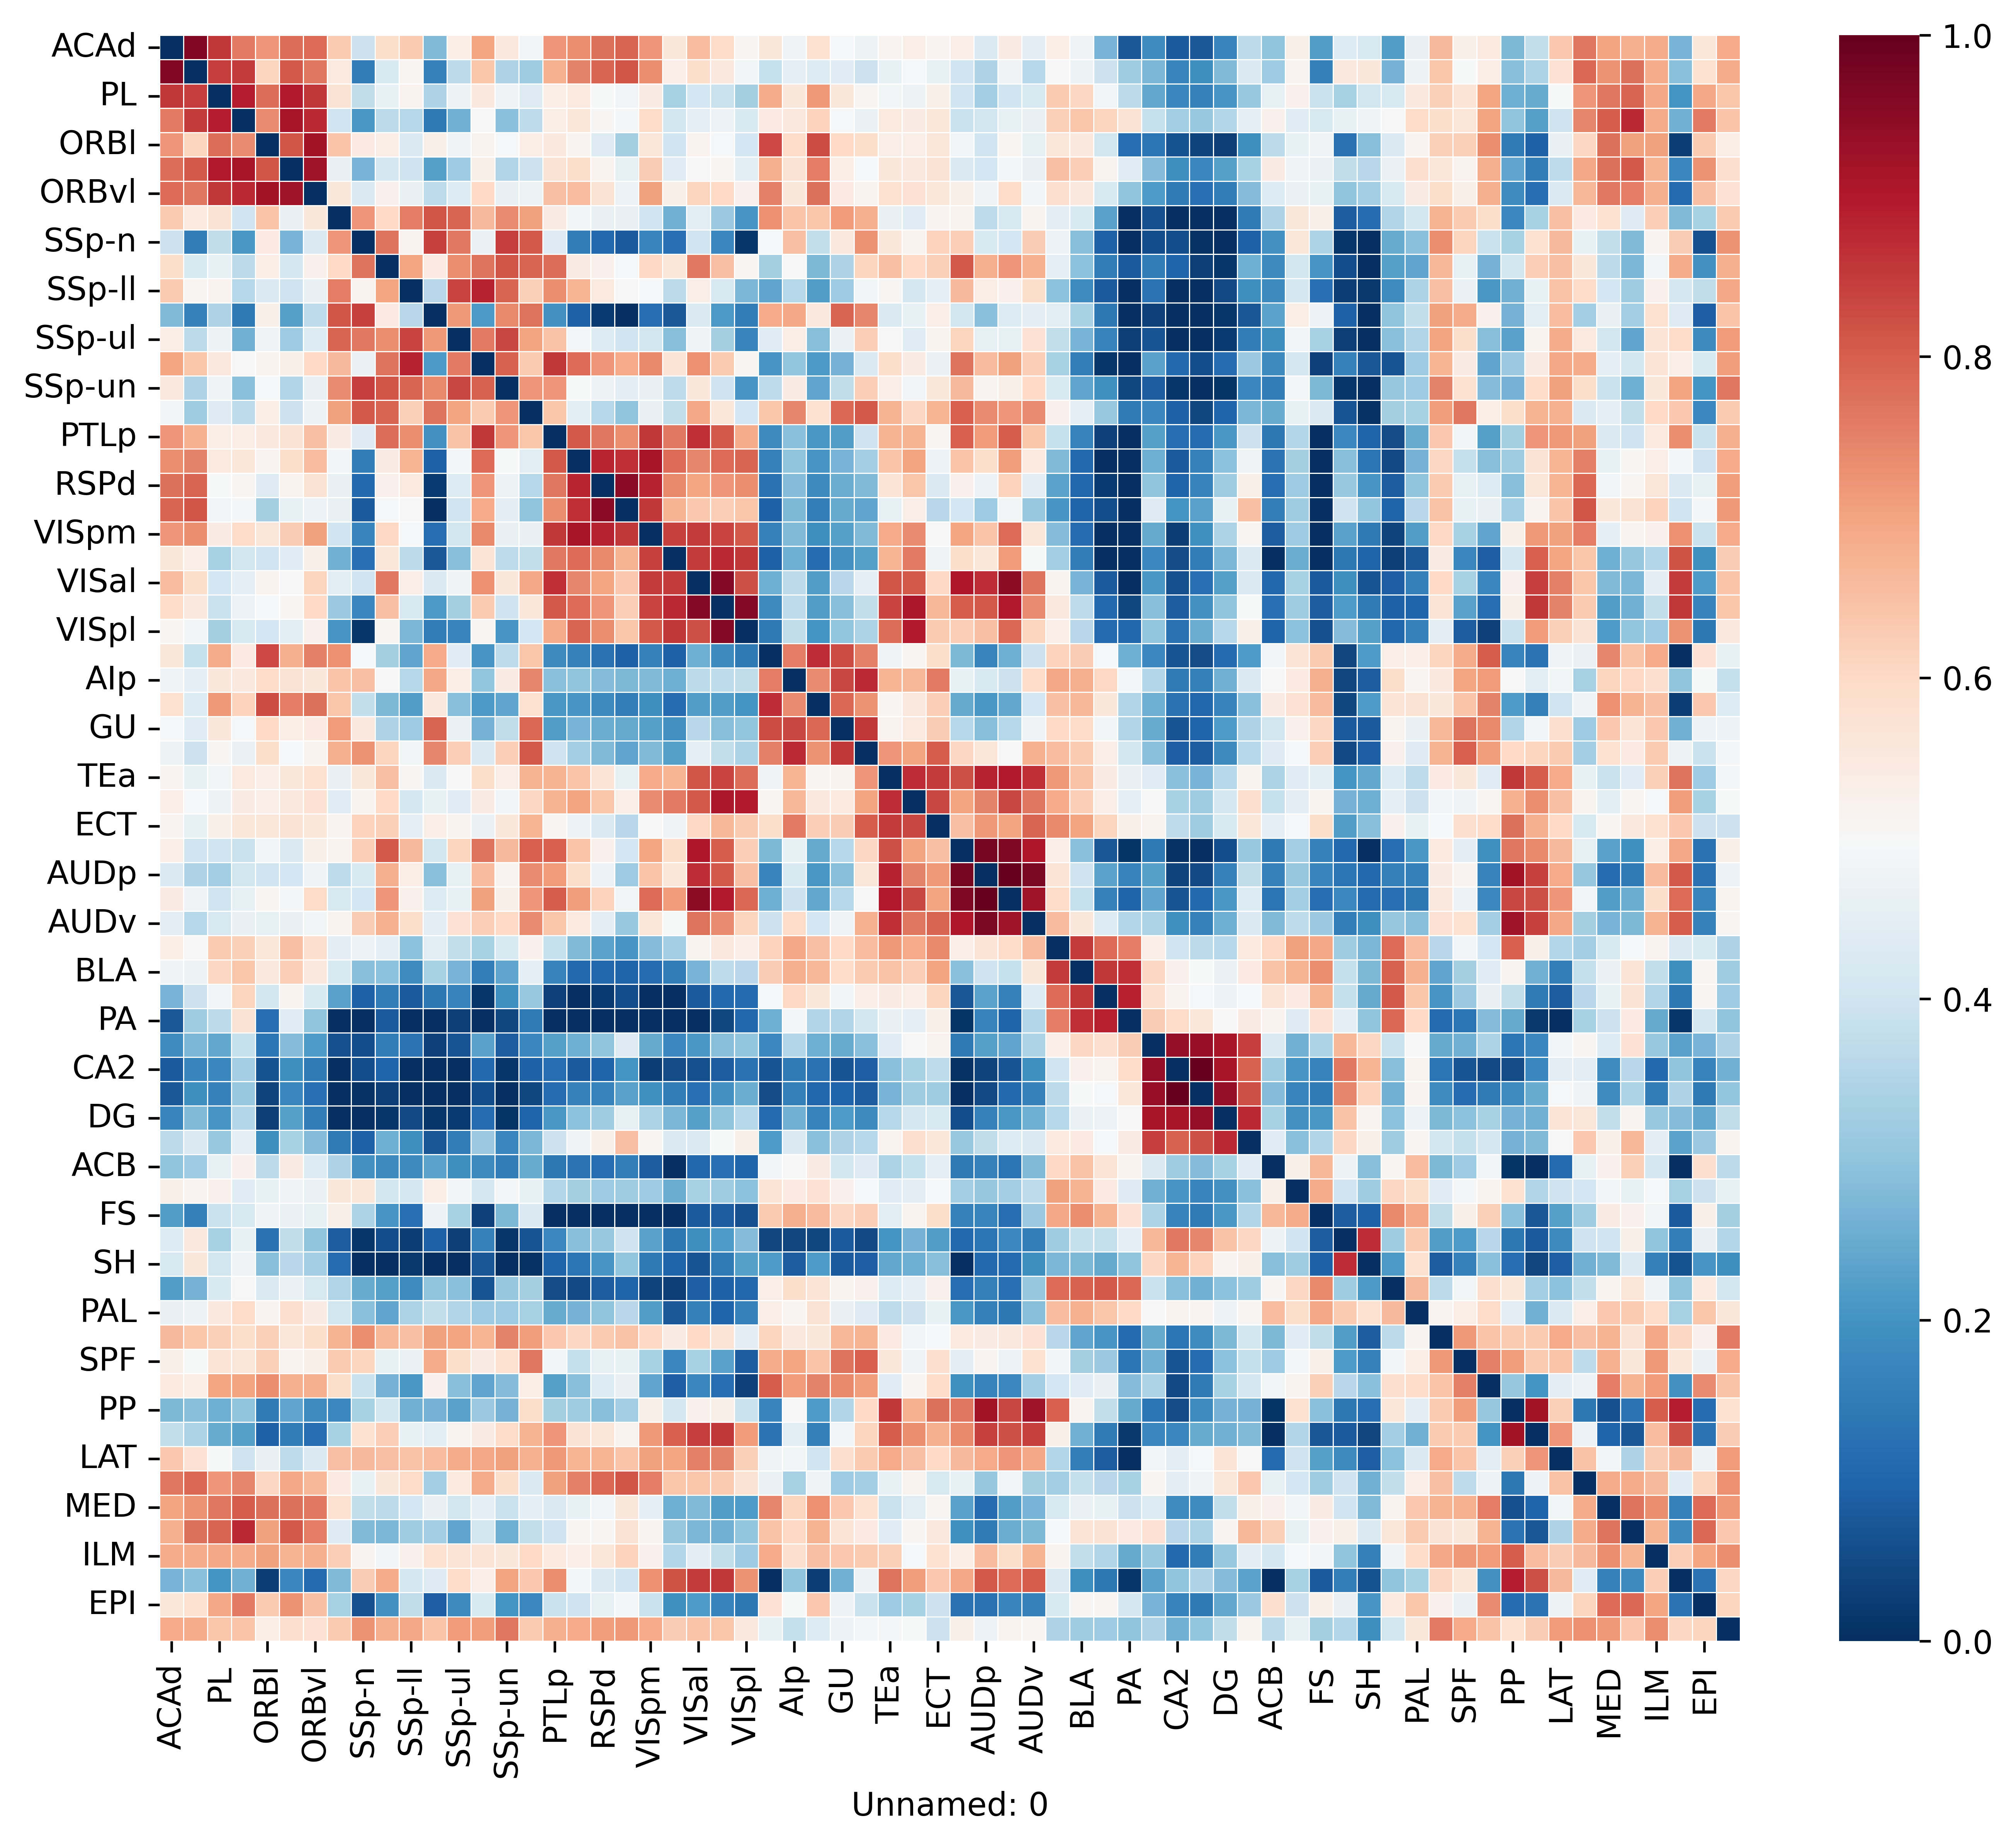

In [22]:
f, ax = plt.subplots(figsize=(11, 9),dpi=600)
sns.heatmap(Mouse_tracer_dataframe,linewidths=0.3,cmap='RdBu_r',vmin=0)

### Load anatomical hierachy constraint information

In [83]:
hier_table = pd.read_excel('./files/hierarchical_brain_relationships.xlsx')

In [84]:
cortex_similarity_dataframe = pd.read_csv('./files/net_emd_mean_dataframe_cortex.csv') # Region-specific TR similarity from embeddings of detached model
cortex_similarity_dataframe.set_index('Unnamed: 0',inplace=True,drop=True)
cortex_similarity_dataframe = cortex_similarity_dataframe[human_select_cortex_region]
cortex_similarity_dataframe = cortex_similarity_dataframe.T[mouse_select_cortex_region].T

In [85]:
subcortex_similarity_dataframe = pd.read_csv('./files/net_emd_mean_dataframe_subcortex.csv')
subcortex_similarity_dataframe.set_index('Unnamed: 0',inplace=True,drop=True)
subcortex_similarity_dataframe = subcortex_similarity_dataframe.T[mouse_select_subcortex_region].T


In [86]:
corr_matrix_mean = np.zeros((len(Human_select_region),len(Mouse_select_region)))
corr_matrix_mean[:len(human_select_cortex_region),:len(mouse_select_cortex_region)] = cortex_similarity_dataframe.T.values
corr_matrix_mean[len(human_select_cortex_region):,len(mouse_select_cortex_region):] = subcortex_similarity_dataframe.T.values
corr_matrix_mean_dataframe = pd.DataFrame(corr_matrix_mean,index=Human_select_region,columns=Mouse_select_region)

Visualization of cross-species transcriptional similarity with hierarchical constraints

[Text(0.5, 16.888888888888864, ''), Text(34.888888888888864, 0.5, '')]

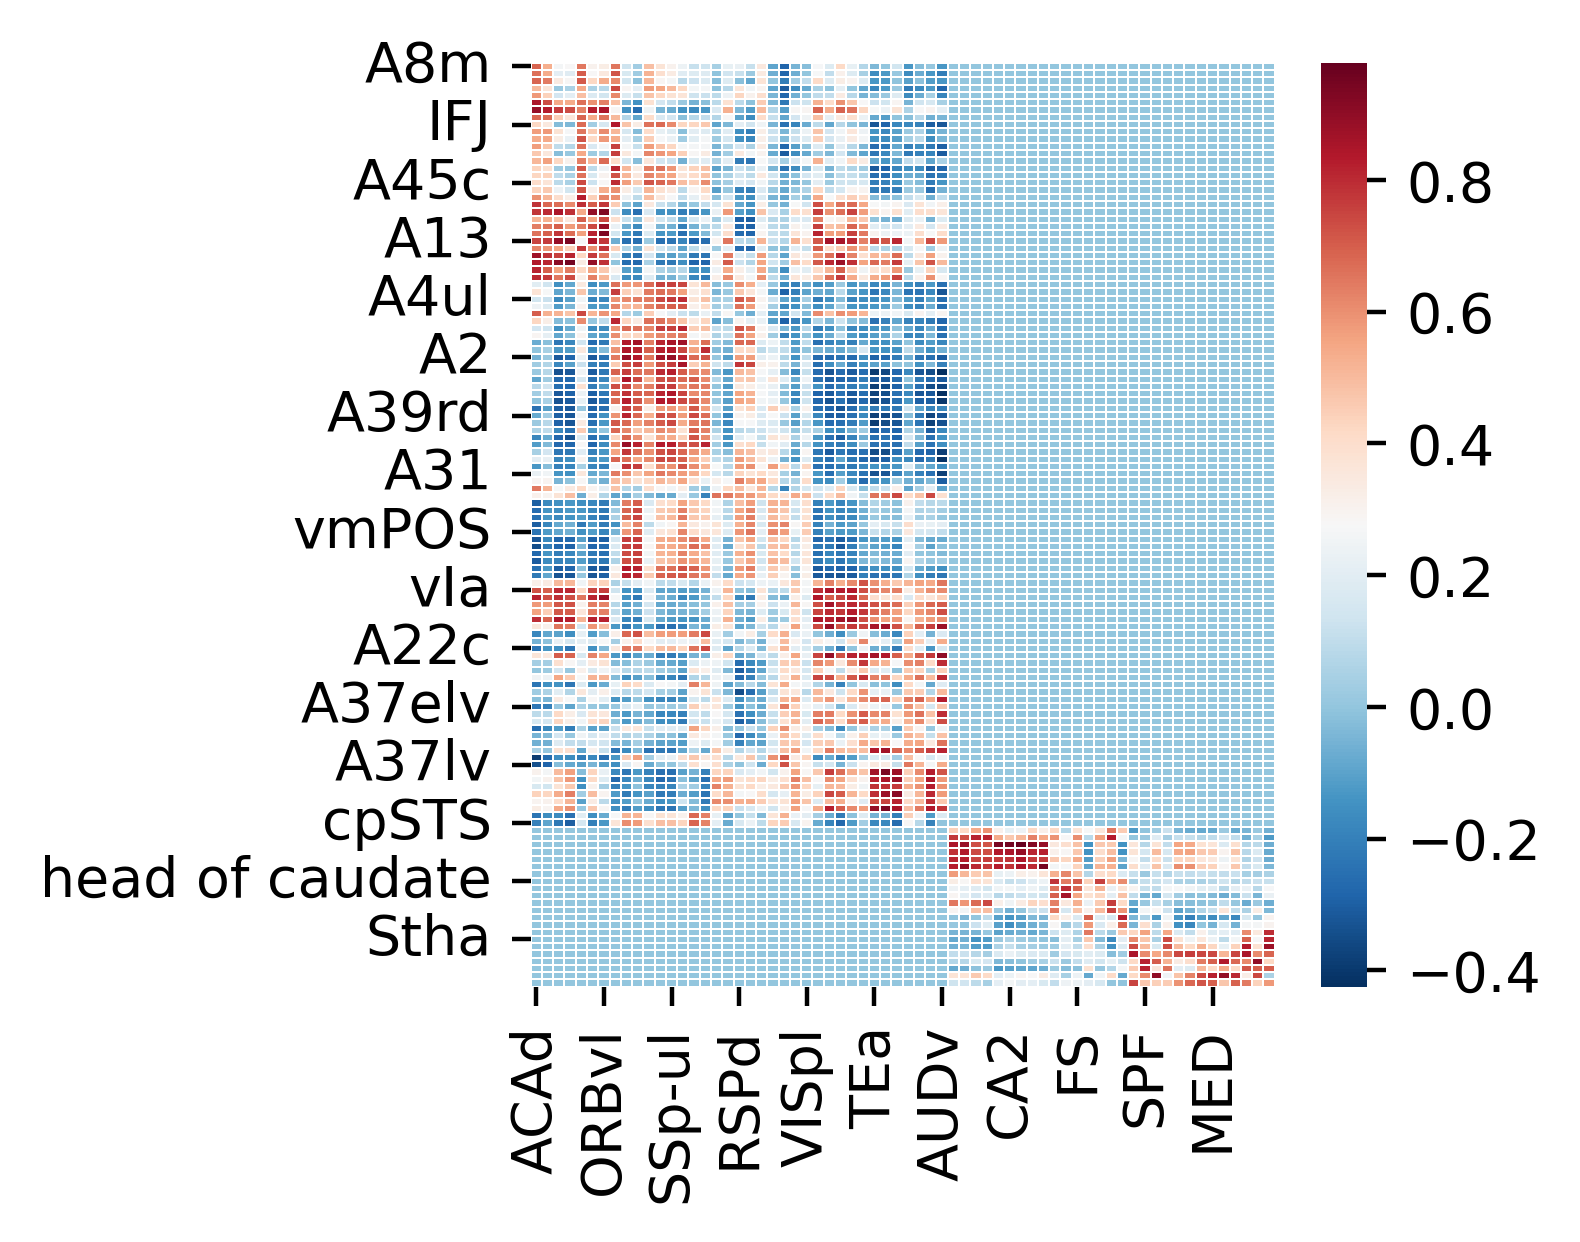

In [87]:
fig,ax=plt.subplots(1,1,figsize=(3,3),dpi=400)
sns.heatmap(corr_matrix_mean_dataframe,cmap='RdBu_r',linewidths=0.3)
ax.set(xlabel="", ylabel="")

In [88]:
Sparse_matrix = np.zeros_like(corr_matrix_mean_dataframe.values)

In [89]:
Sparse_matrix_dataframe=pd.DataFrame(Sparse_matrix)

In [90]:
Sparse_matrix_dataframe.index = corr_matrix_mean_dataframe.index
Sparse_matrix_dataframe.columns = corr_matrix_mean_dataframe.columns

In [91]:
for i in range(11):
    for h_n in [item.strip().strip("'") for item in hier_table['Human Regions'].iloc[i].split(",")]:
        for m_n in [item.strip().strip("'") for item in hier_table['Mouse Regions'].iloc[i].split(",")]:
            Sparse_matrix_dataframe.loc[h_n,m_n] = corr_matrix_mean_dataframe.loc[h_n,m_n]

In [92]:
Sparse_matrix[Sparse_matrix<0]=0

[Text(0.5, 16.888888888888864, ''), Text(34.888888888888864, 0.5, '')]

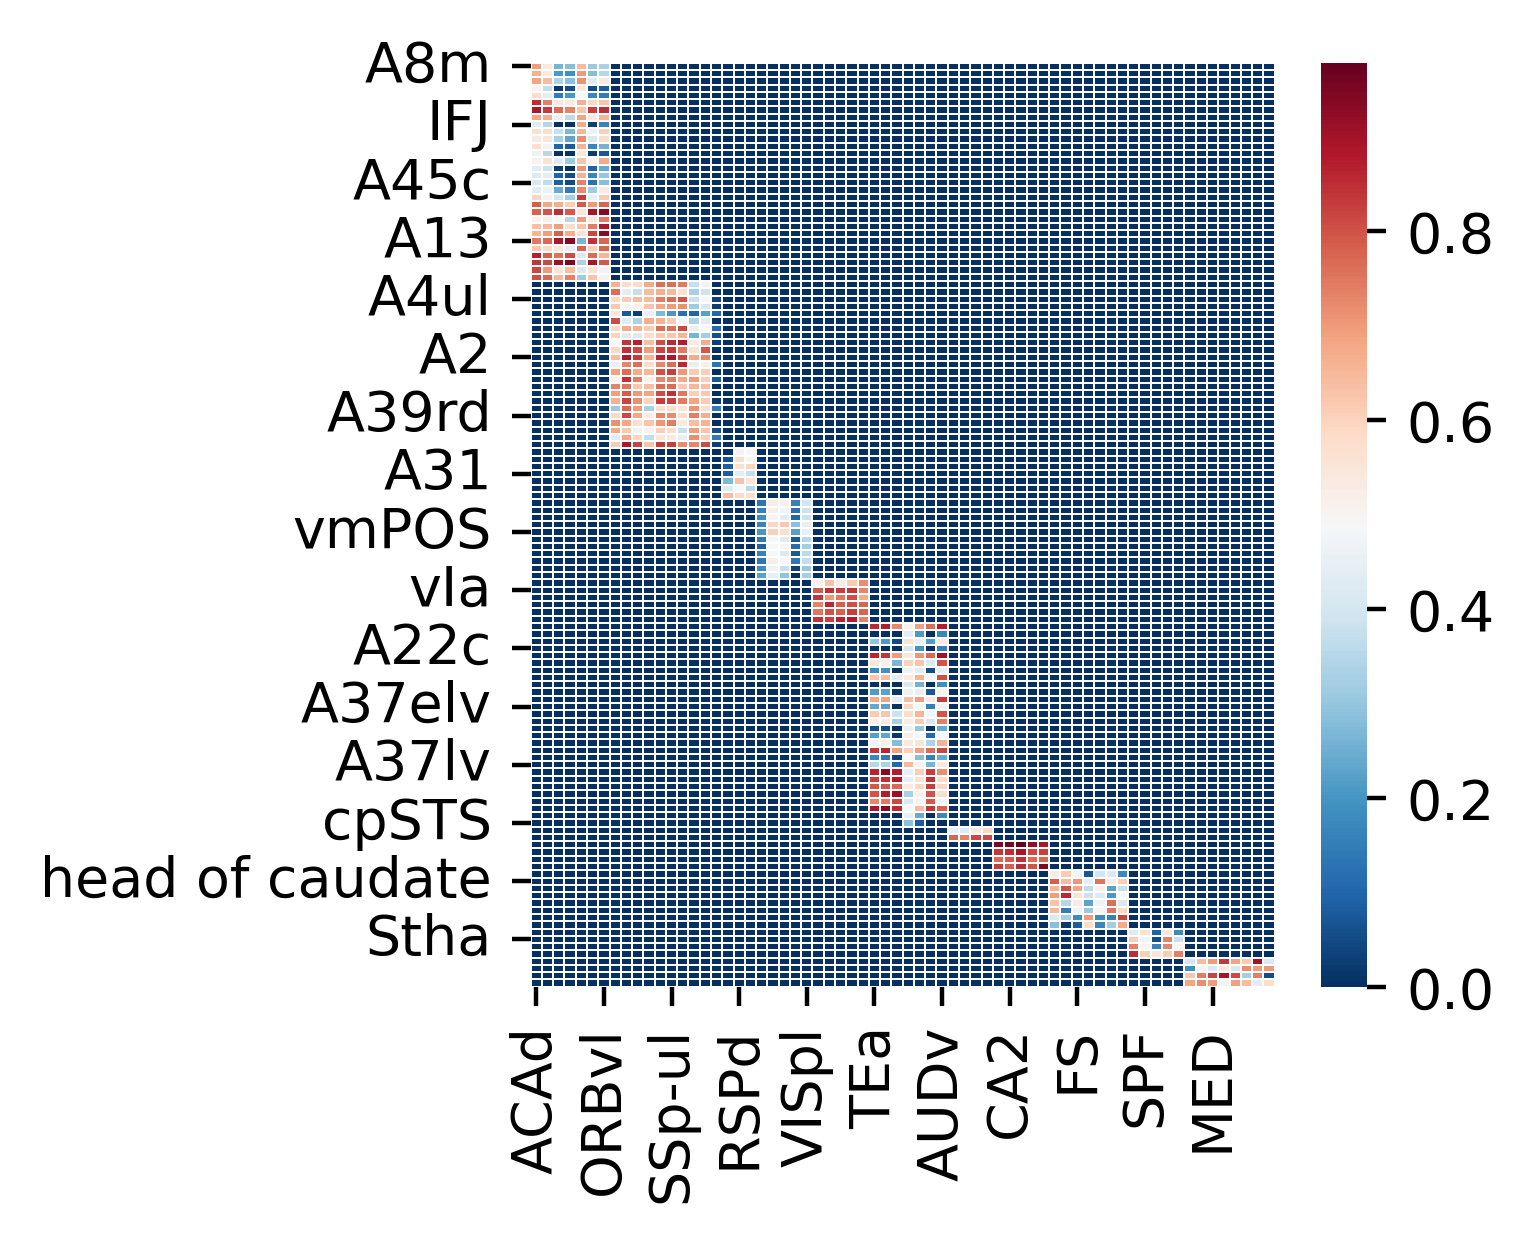

In [93]:
fig,ax=plt.subplots(1,1,figsize=(3,3),dpi=400)
sns.heatmap(Sparse_matrix_dataframe,cmap='RdBu_r',linewidths=0.3,vmin=0)
ax.set(xlabel="", ylabel="")

In [94]:
embedding_input=np.zeros((193,193))
embedding_input[:127,:127] = Human_dti_dataframe.values
embedding_input[:127,127:] = Sparse_matrix_dataframe.values
embedding_input[127:,:127] = Sparse_matrix_dataframe.T.values
embedding_input[127:,127:] = Mouse_tracer_dataframe.values

In [95]:
region_labels = human_select_cortex_region + ['mAmyg', 'lAmyg', 'CA1', 'CA4DG', 'CA2CA3', 'subiculum', 'Claustrum','CaH','CaB', 'Putamen','PVP','NAC',
       'GPe','GPi', 'mPMtha','Stha', 'PPtha', 'Otha','mPFtha', 'lPFtha', 'rTtha', 'cTtha'] + Mouse_select_region

In [96]:
embedding_input = pd.DataFrame(embedding_input,index=region_labels,columns=region_labels)

## Random Walk

In [97]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
font_path ='../../tutorials/whitney-medium.otf'
custom_font = FontProperties(fname=font_path)
from matplotlib.patches import Rectangle

In [98]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb

In [99]:
original_cmap = plt.get_cmap("coolwarm")

colors = original_cmap(np.linspace(0, 1, 256))

def adjust_color(color, factor):

    r, g, b, a = color
    hsv = rgb_to_hsv([r, g, b])
    hsv[1] = min(1, hsv[1] * factor) 
    hsv[2] = min(1, hsv[2] * factor) 
    adjusted_rgb = hsv_to_rgb(hsv)
    return np.array([adjusted_rgb[0], adjusted_rgb[1], adjusted_rgb[2], a])  

red_adjustment = 1.5
blue_adjustment = 1.5


for i in range(len(colors)):

    if colors[i, 2] > 0.5: 
        colors[i] = adjust_color(colors[i], blue_adjustment)

    elif colors[i, 0] > 0.5:
        colors[i] = adjust_color(colors[i], red_adjustment)

custom_cmap = LinearSegmentedColormap.from_list("custom_coolwarm_adjusted", colors)

In [100]:
def brighten_cmap(cmap, factor=1.2):

    new_colors = []
    for c in cmap(np.linspace(0, 1, cmap.N)):
        new_color = mcolors.rgb_to_hsv(c[:3])  
        new_color[2] = min(new_color[2] * factor, 1.0)
        new_colors.append(mcolors.hsv_to_rgb(new_color))
    return LinearSegmentedColormap.from_list("bright_plasma", new_colors)

bright_cmap = brighten_cmap(custom_cmap, factor=6)

Visualization of the initial cross-species graph

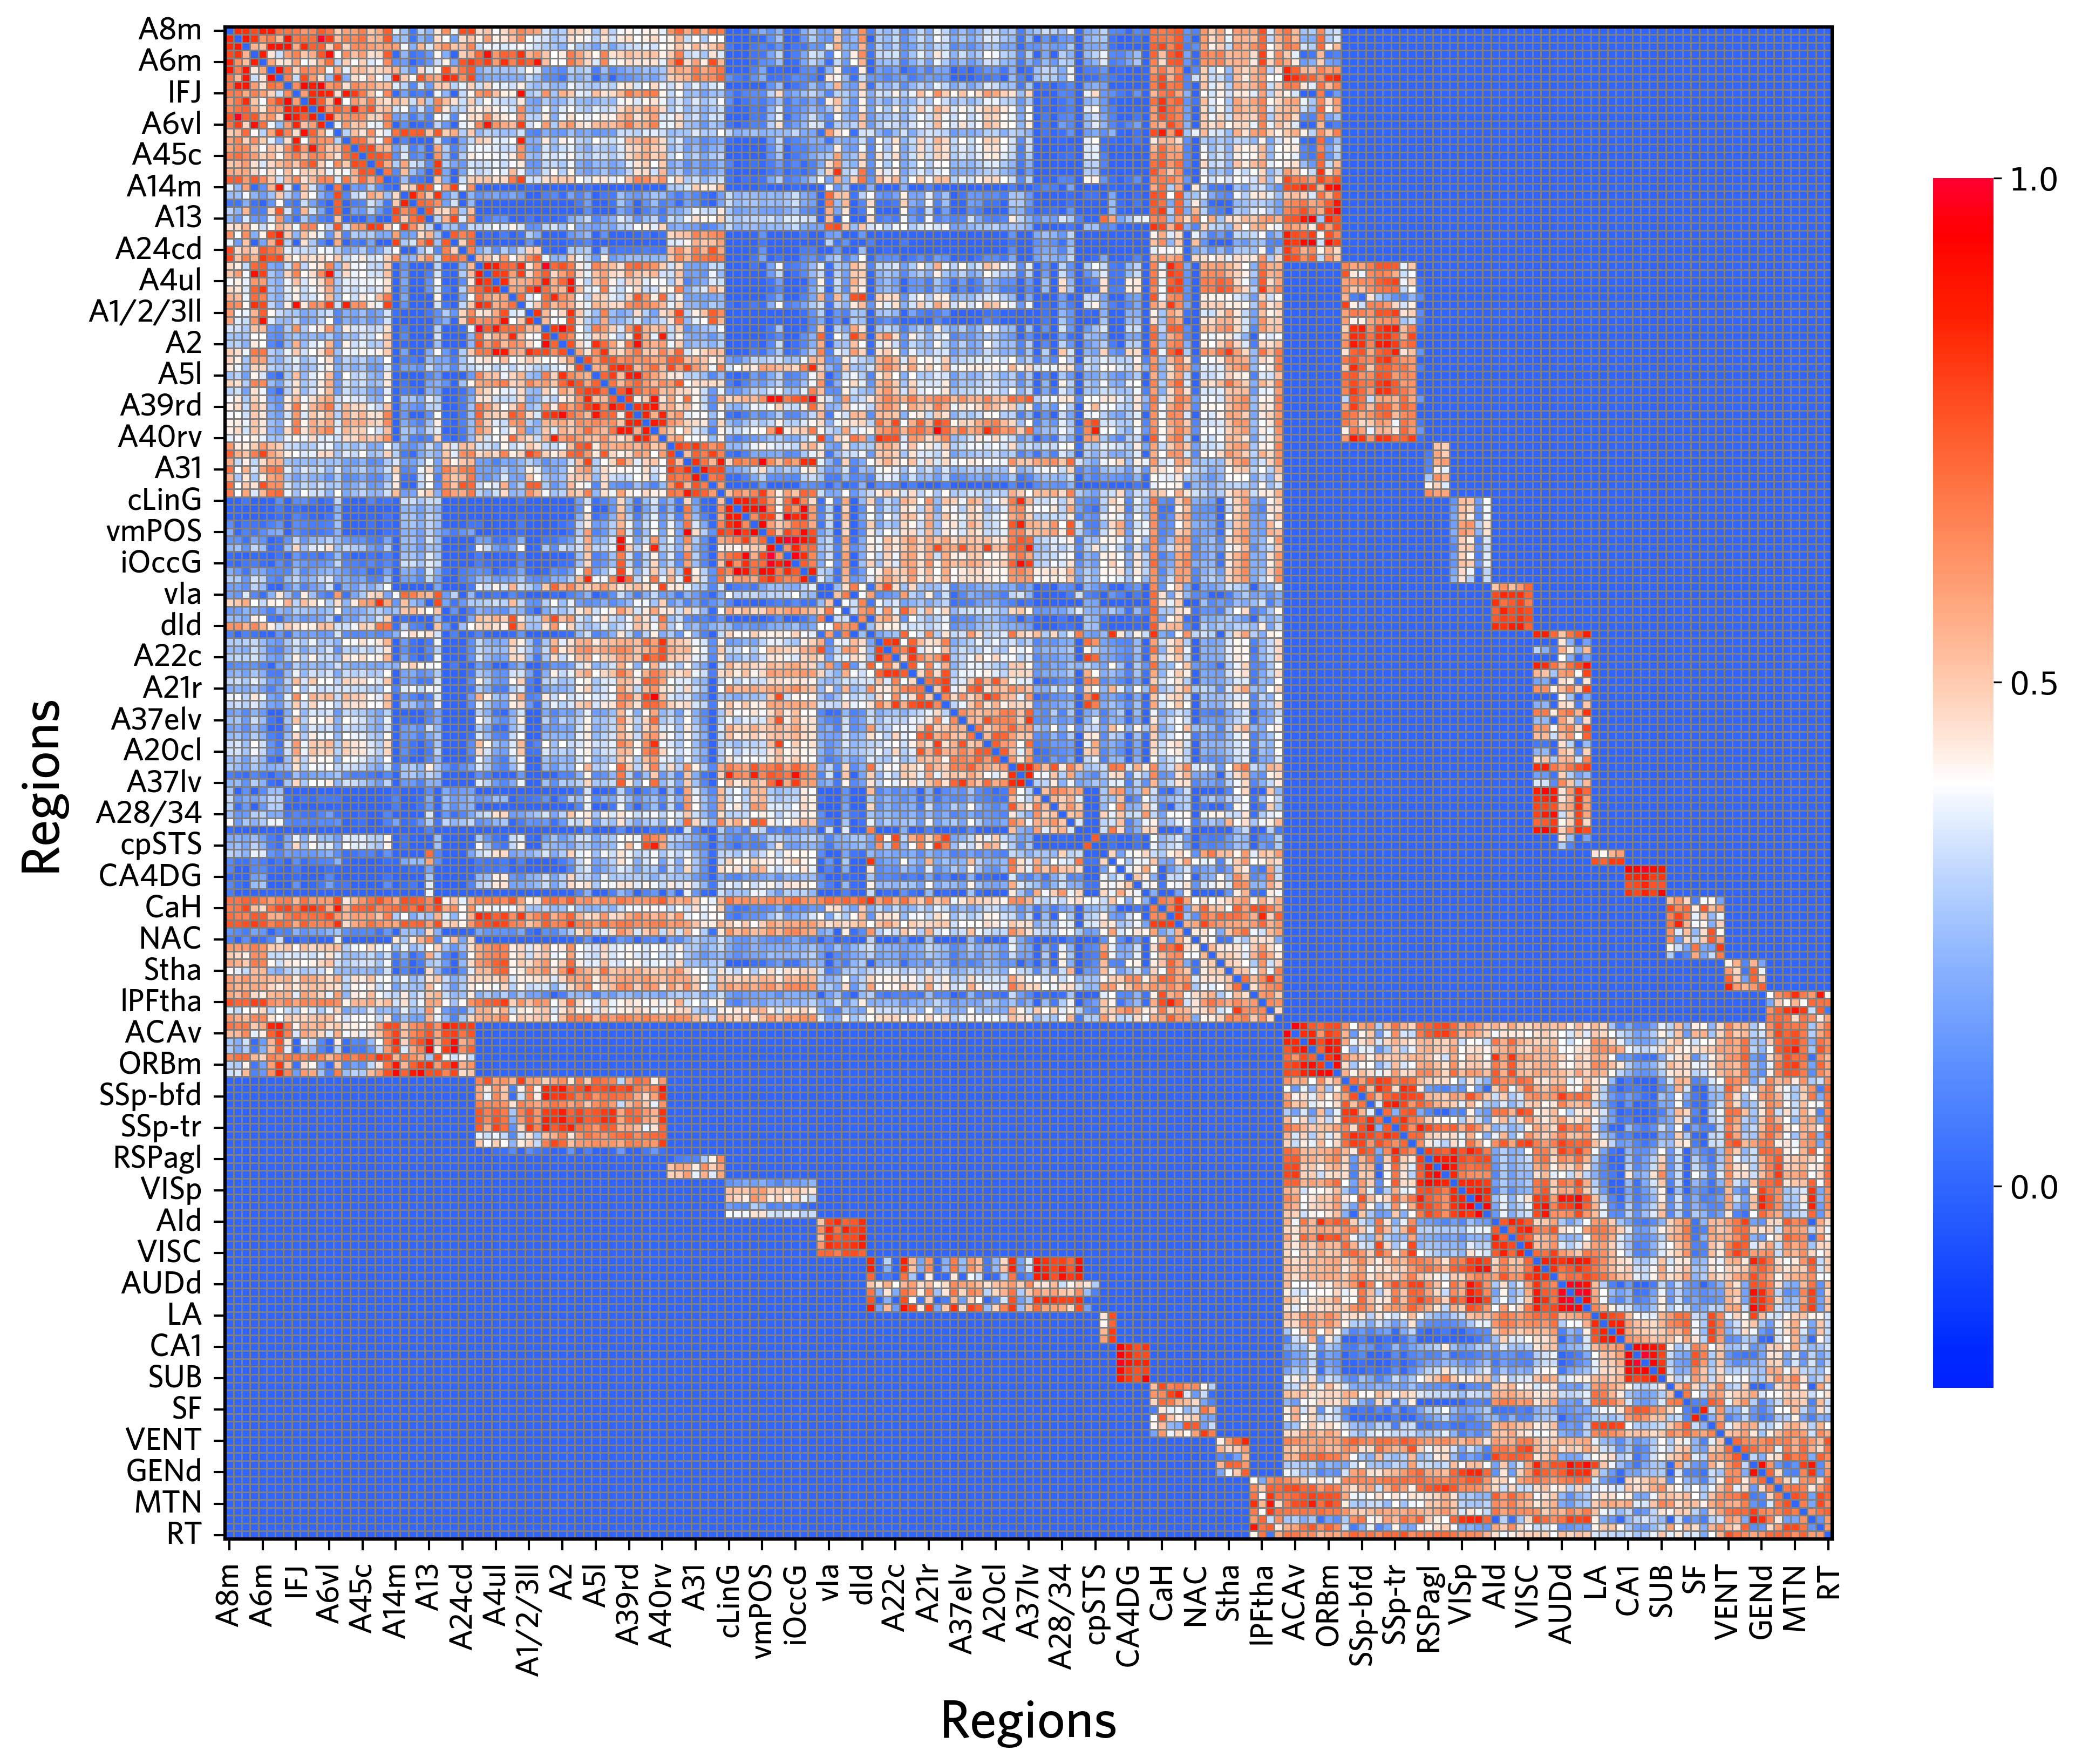

In [101]:
f, ax = plt.subplots(figsize=(14, 11), dpi=300)

heatmap = sns.heatmap(
    embedding_input,
    cmap=bright_cmap, 
    vmin=-0.2,
    vmax=1,  
    linewidths=0.3,  
    linecolor='gray',  
    cbar_kws={
        "orientation": "vertical",  
        "shrink": 0.8,  
        "aspect": 20,  
        "label": "",  
        "ticks": [0, 0.5, 1.0]
    }
)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

ax.set_xlabel("Regions", fontsize=24, labelpad=10, fontproperties=custom_font)
ax.set_ylabel("Regions", fontsize=24, labelpad=10, fontproperties=custom_font)


ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90, fontproperties=custom_font)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0, fontproperties=custom_font)

ax.tick_params(axis='both', which='both', length=5, width=1, pad=5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for spine in ax.spines.values():
    spine.set_visible(True)  
    spine.set_color('black')
    spine.set_linewidth(1.5)

plt.tight_layout()

plt.show()

In [102]:
embedding_input_dataframe=pd.DataFrame(embedding_input)
# embedding_input_dataframe.to_csv('mouse_human_embedding_input.csv')

## Generate graph embeddings

In [1]:
#! python ../code/graph_walk/run.py -i ./mouse_human_embedding_input.csv -s graph_embedding -p 0.01 -q 0.1 -pm 500  # Generate graph embeddings

In [104]:
def get_embedding_map(p,q):    
    with open("./graph_embedding/Human_Mouse_p{}_q{}_graph_embeddings.pkl".format(p,q),'rb') as f:
        embedding_data=pickle.load(f)
    embedding_zero=np.zeros((500,386,386))
    for i in range(500):
        embeeding_corr=np.corrcoef(embedding_data[i],embedding_data[i])
        embedding_zero[i]=embeeding_corr
    aver_embedding=np.mean(embedding_zero,axis=0)
    embedding_map=pd.DataFrame(aver_embedding[:193,193:])
    return embedding_map

In [105]:
embedding_map=get_embedding_map(0.01,0.1)

In [106]:
embedding_map.index = region_labels
embedding_map.columns = region_labels

Visualization of final obtained cross-species average graph embeddings

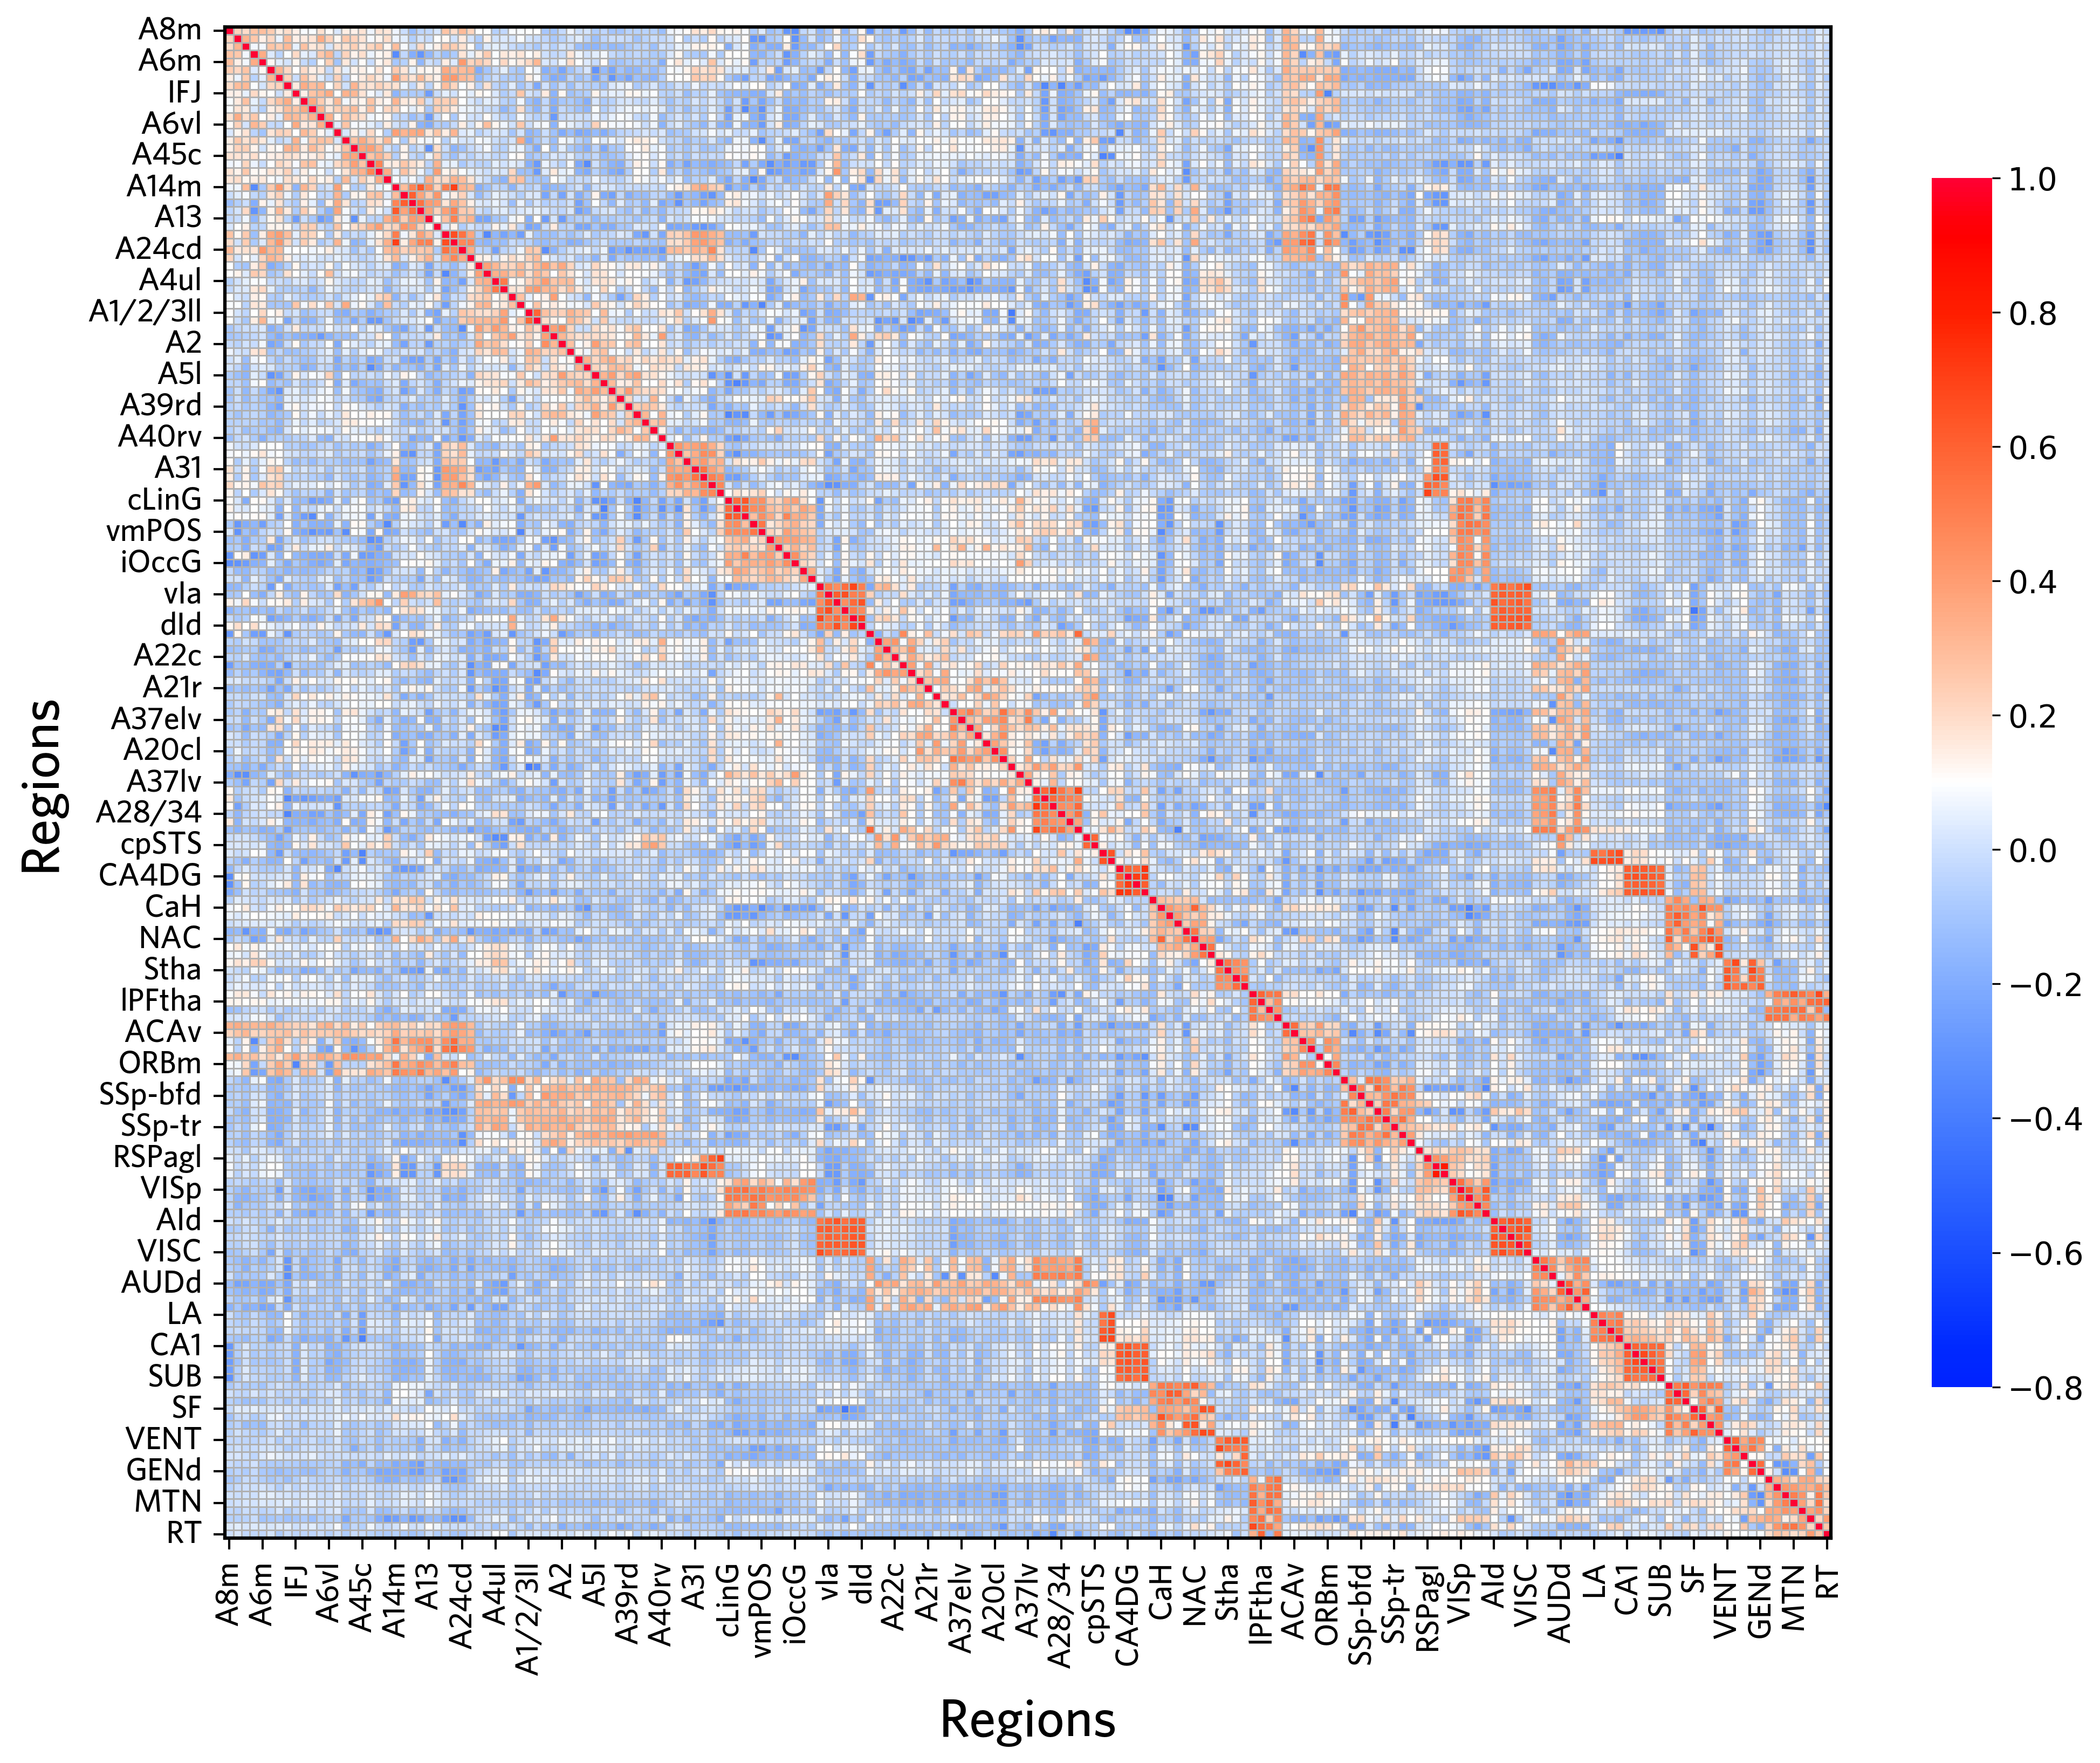

In [107]:
f, ax = plt.subplots(figsize=(14, 11), dpi=300)

heatmap = sns.heatmap(
    embedding_map,
    cmap= bright_cmap,  
    vmin=-0.8,
    vmax=1,  
    linewidths=0.3, 
    linecolor='#B0B0B0',  
    cbar_kws={
        "orientation": "vertical", 
        "shrink": 0.8,  
        "aspect": 20,  
        "label": "" 
    }
)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

ax.set_xlabel("Regions", fontsize=24, labelpad=10, fontproperties=custom_font)
ax.set_ylabel("Regions", fontsize=24, labelpad=10, fontproperties=custom_font)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90, fontproperties=custom_font)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0, fontproperties=custom_font)

ax.tick_params(axis='both', which='both', length=5, width=1, pad=5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for spine in ax.spines.values():
    spine.set_visible(True)  
    spine.set_color('black')
    spine.set_linewidth(1.5)

plt.tight_layout()

plt.show()